In [1]:
import importlib
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
from multi_loc import covariance, assimilate

In [93]:
%matplotlib inline

In [111]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [212]:
dimension = 2**9
print(dimension)
rho0 = 0.1
# dx = 0.25
dx = 1/dimension

obs_size = int(dimension/2)
H = assimilate.random_H(dimension, obs_size)

# H = np.eye(dimension)[::2]

rho = np.arange(dimension, dtype=float)
rho = np.minimum(rho, (dimension - rho) % dimension)
rho = rho*dx

512


In [213]:
eig_val, eig_vec, P, sort_ind = covariance.generate_circulant(
    dimension, dx, rho0, covariance.fft_sqd_exp_1d,
    return_Corr=True,
    return_sort_ind=True)
eig_val = eig_val * (eig_val.size/eig_val.sum())
eig_vec = eig_vec.real + eig_vec.imag
# sort_ind = np.argsort(sort_ind)
# eig_val = eig_val[sort_ind]
# eig_vec = eig_vec[:, sort_ind]
# eig_val = np.fft.fftshift(eig_val)
# eig_vec = np.fft.fftshift(eig_vec, axes=1)

P = eig_vec @ np.diag(eig_val) @ eig_vec.conj().T
P = P.real

R = np.eye(obs_size)

<IPython.core.display.Javascript object>


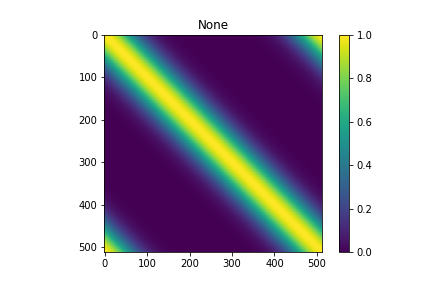

<IPython.core.display.Javascript object>


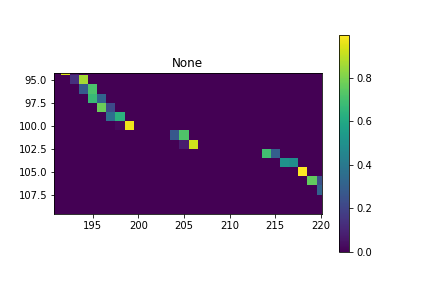

In [245]:
imshow(P, vmin=0)
imshow(H)

In [215]:
trans_mats = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)

for key, val in trans_mats.items():
    exec(key + '=val')

In [243]:
%matplotlib notebook

<IPython.core.display.Javascript object>


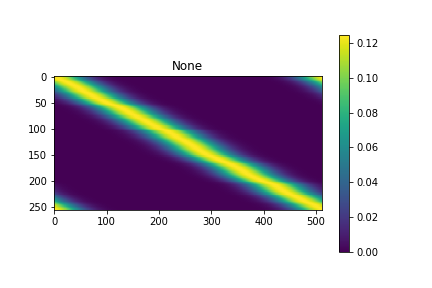

<IPython.core.display.Javascript object>


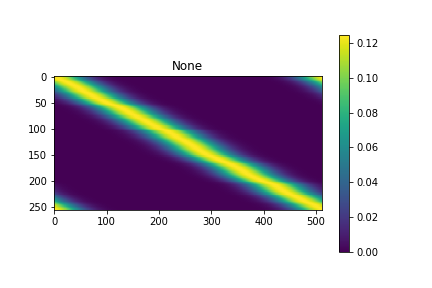

In [244]:
imshow(U @ S @ VT)
imshow(H @ P_sqrt)

/Users/harty/anaconda3/envs/multiloc/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


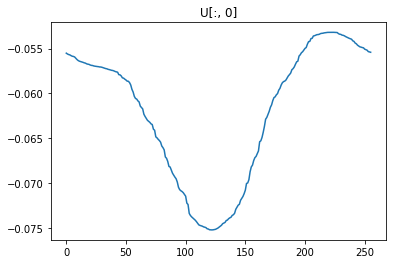

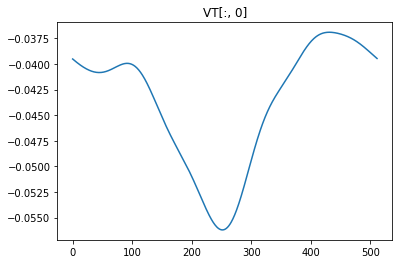

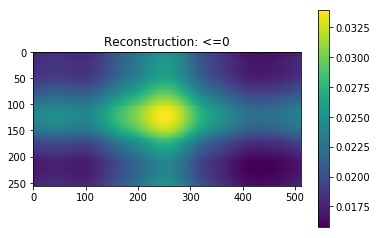

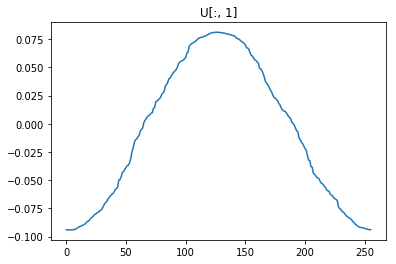

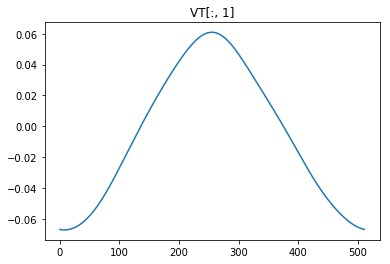

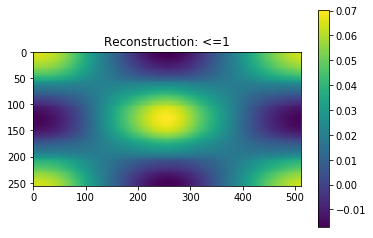

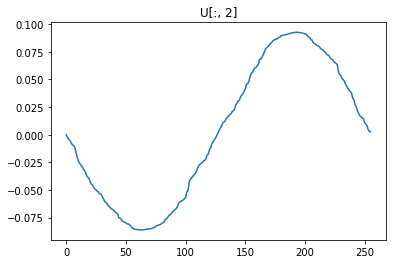

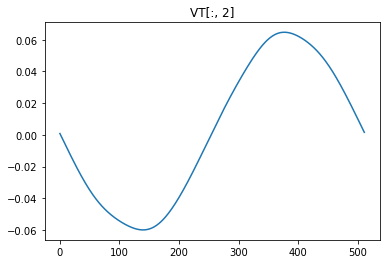

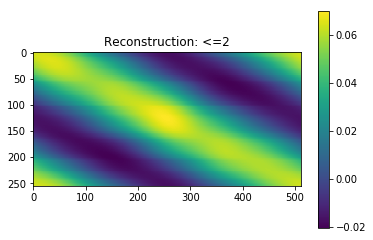

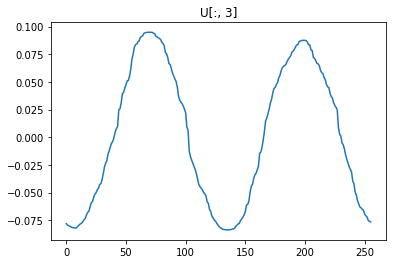

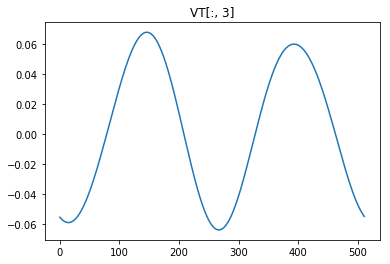

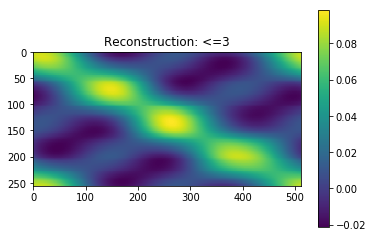

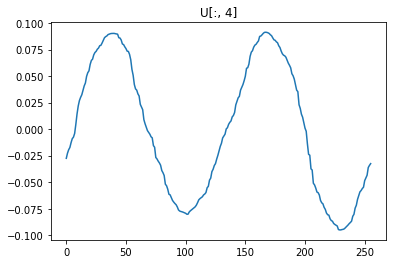

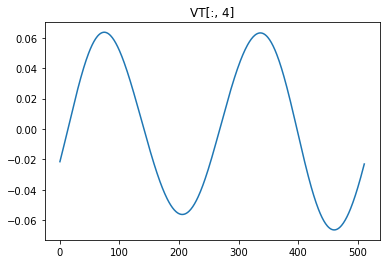

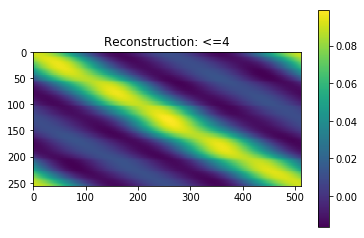

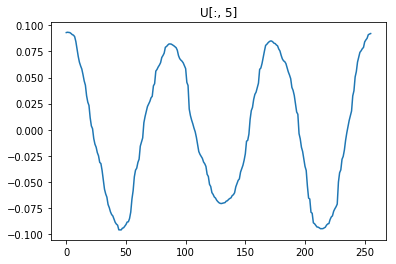

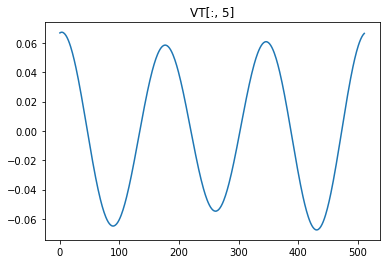

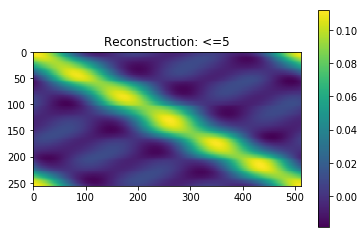

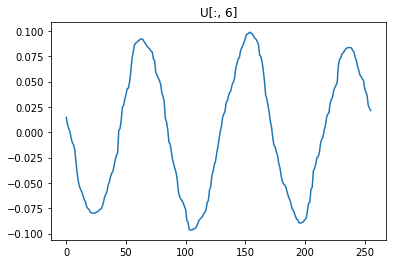

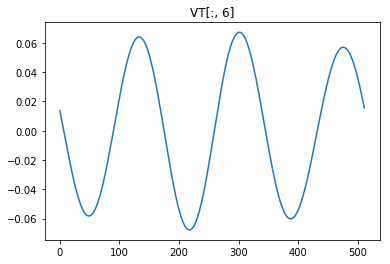

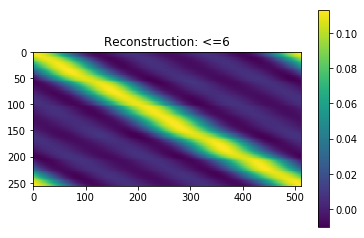

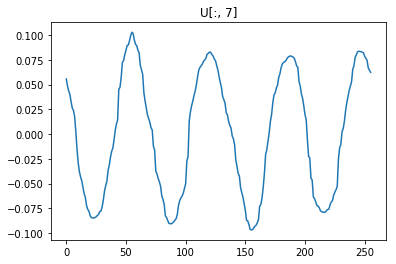

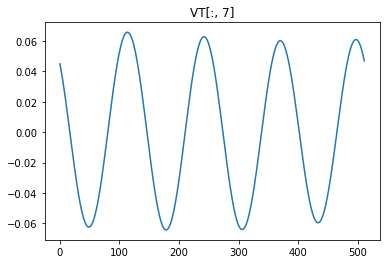

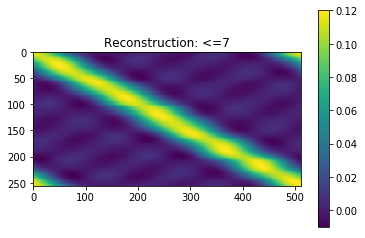

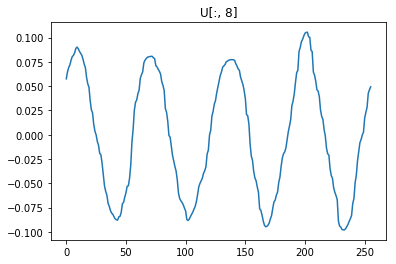

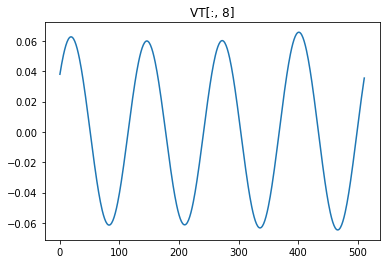

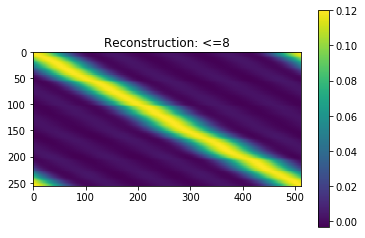

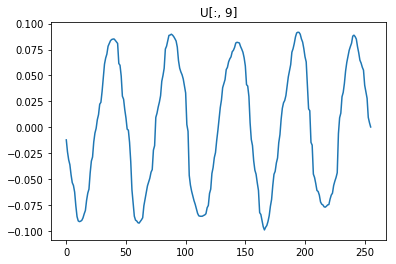

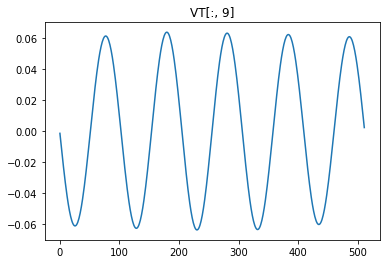

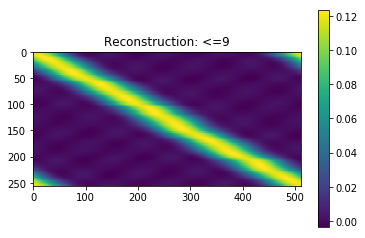

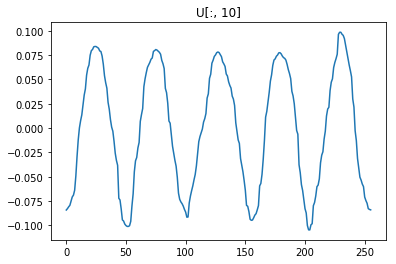

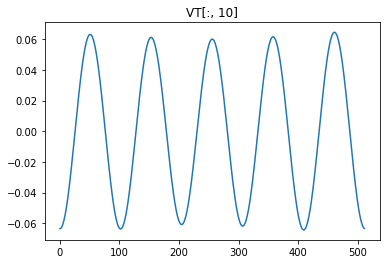

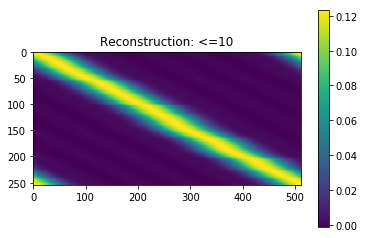

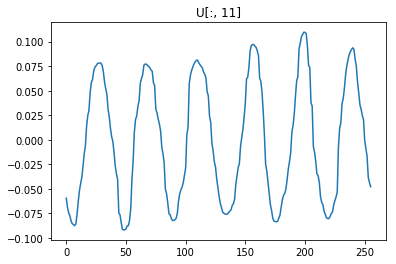

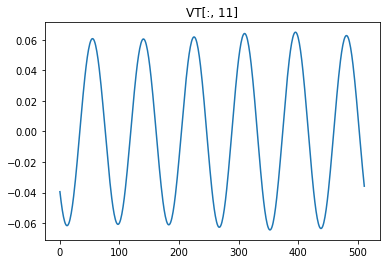

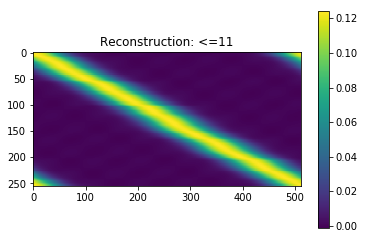

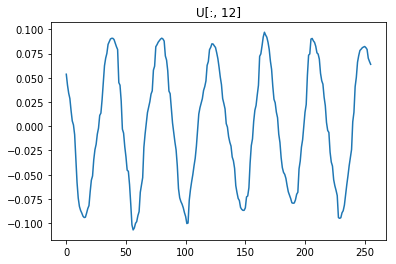

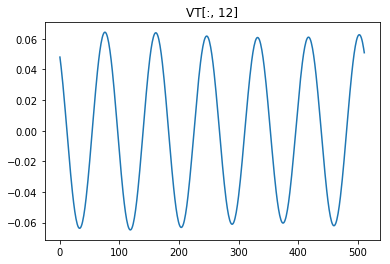

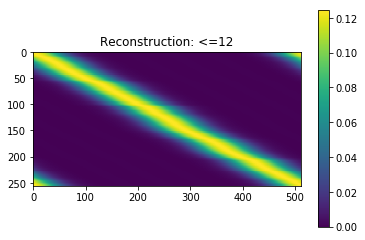

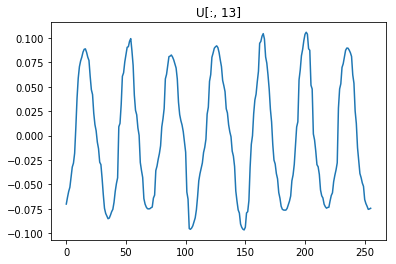

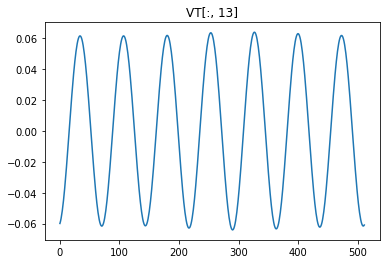

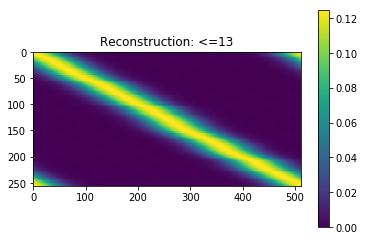

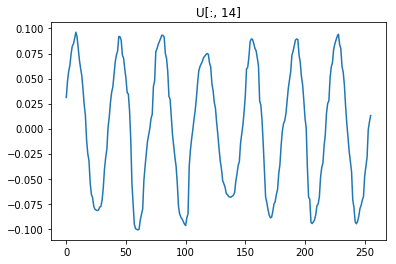

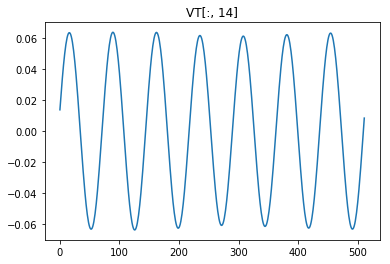

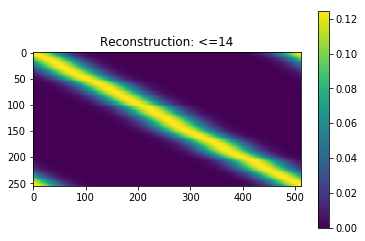

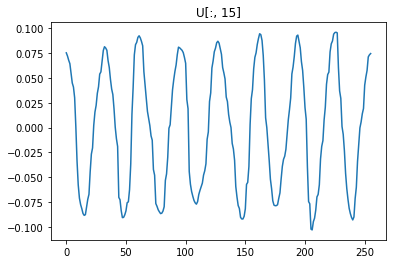

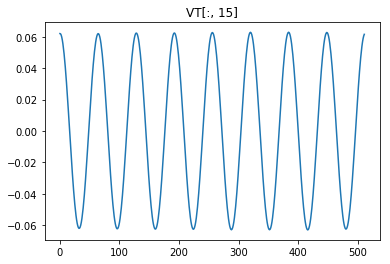

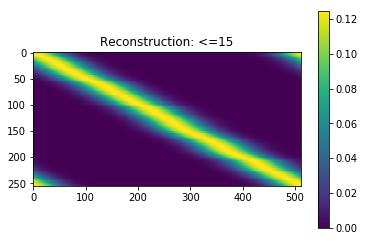

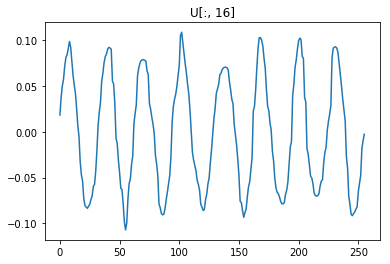

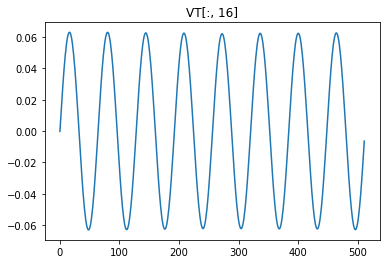

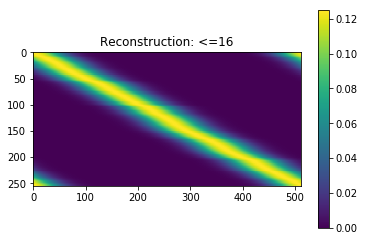

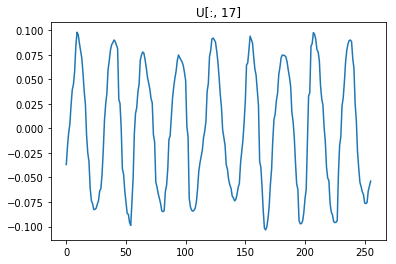

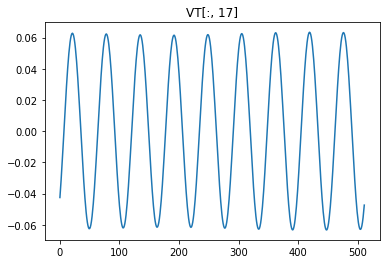

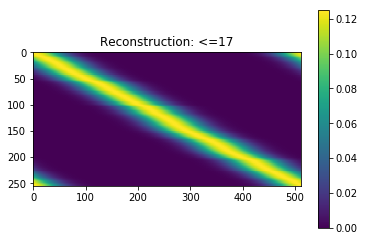

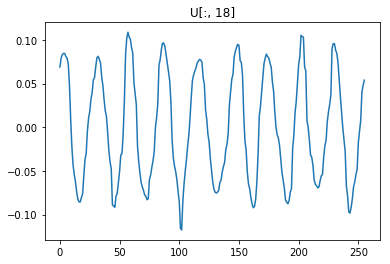

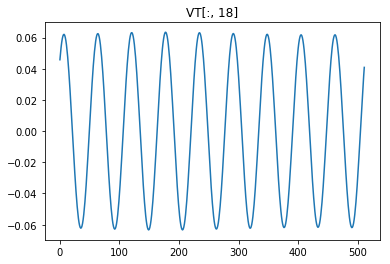

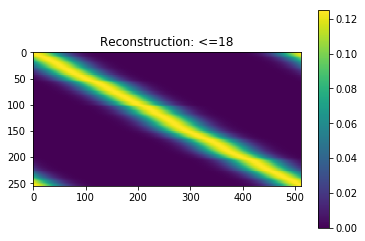

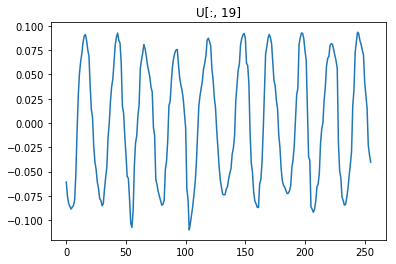

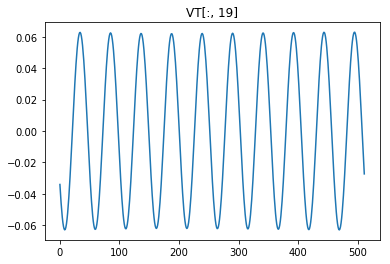

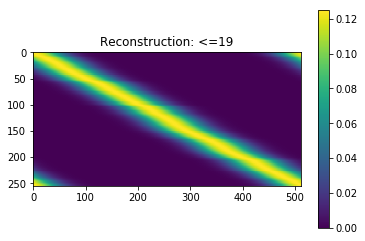

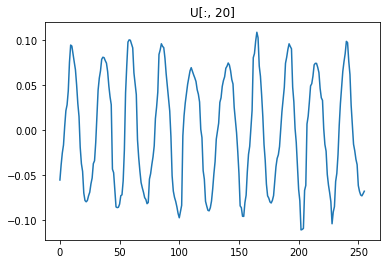

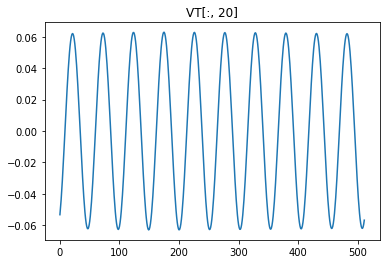

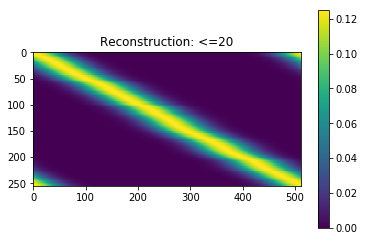

In [218]:
prev = np.zeros_like(S)
for ii in range(21):
    plt.figure()
    plt.plot(U[:, ii])
    plt.title(f'U[:, {ii}]')
    
    plt.figure()
    plt.plot(VT[ii])
    plt.title(f'VT[:, {ii}]')
    
    prev += (S.diagonal()[ii]
             * U[:, ii:ii+1]
             @ VT[ii:ii + 1])
    
    imshow(prev, f'Reconstruction: <={ii}')

In [353]:
ens_size = 50
mu = np.zeros(dimension)

In [354]:
ensemble = assimilate.generate_ensemble(
    ens_size, mu, trans_mats['P_sqrt'])

In [355]:
rho0

0.1

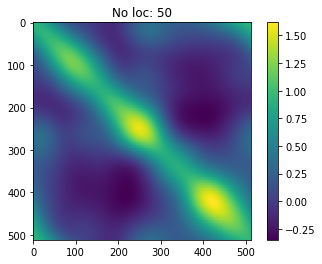

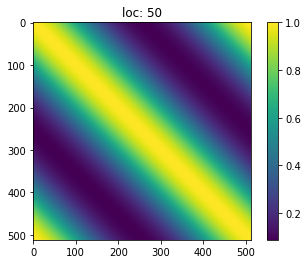

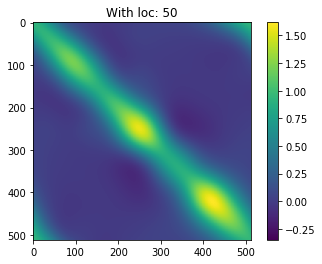

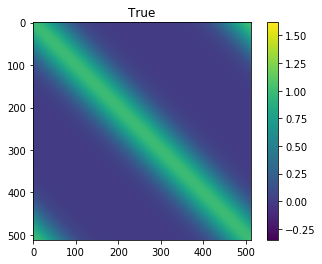

In [356]:
rho_loc = 0.2
[loc] = covariance.generate_circulant(
    dimension, dx, rho_loc, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_eig=False)
loc /= loc.max()
P_sample = np.cov(ensemble)
vmin = P_sample.min()
vmax = np.max([P_sample.max(), 1])
imshow(P_sample,
       vmin=vmin, vmax=vmax,
       title=f'No loc: {ens_size}')

imshow(loc,
       title=f'loc: {ens_size}')
imshow(P_sample * loc,
       vmin=vmin, vmax=vmax,
       title=f'With loc: {ens_size}')
imshow(P,
       vmin=vmin, vmax=vmax,
       title=f'True')

In [374]:
trans_mats_sample = assimilate.transformation_matrices(
        H, P=P_sample,
        R=R, return_Ts=True)
U_sample = trans_mats_sample['U']
S_sample = trans_mats_sample['S']
VT_sample = trans_mats_sample['VT']

Text(0.5,0,'localization radius')

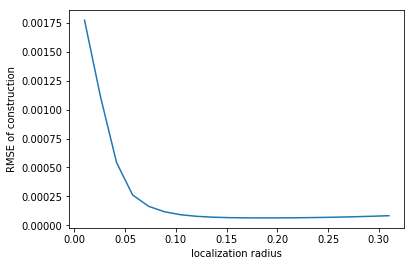

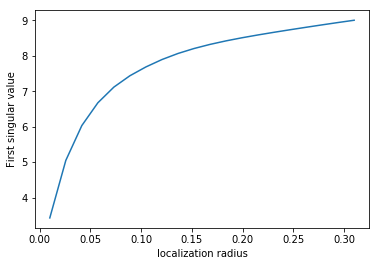

In [372]:
sig_num = 5
reduced_true = U[:, :sig_num] @ S[:sig_num, :sig_num] @ VT[:sig_num]
# imshow(reduced_true, f'Reduced true; sig_num: {sig_num}')
rho_array = np.linspace(.31, 0.01, 20)
rmse = np.ones_like(rho_array) * np.nan
first_singular = rmse.copy()
for count, rho_loc in enumerate(rho_array):
    [loc] = covariance.generate_circulant(
        dimension, dx, rho_loc, covariance.fft_sqd_exp_1d,
        return_Corr=True, return_eig=False)
    loc /= loc.max() 
    P_loc = P_sample * loc
#     imshow(P_loc, f'P_loc: {rho_loc:0.3}')
    this_trans_mats = assimilate.transformation_matrices(
        H, P=P_loc,
        R=R, return_Ts=True)
    aU = this_trans_mats['U']
    aS = this_trans_mats['S']
    aVT = this_trans_mats['VT']
    first_singular[count] = aS[0,0]
    this_reduced = (aU[:, :sig_num]
                    @ aS[:sig_num, :sig_num]
                    @ aVT[:sig_num])
#     imshow(this_reduced, f'Reduced sample; rho: {rho_loc:0.3}')
    error = this_reduced - reduced_true
    rmse[count] = (error ** 2).mean()
#     imshow(error, f'Error; rmse: {rmse[count]:0.4}')
    
plt.figure()
plt.plot(rho_array, rmse)
plt.ylabel('RMSE of construction')
plt.xlabel('localization radius')


plt.figure()
plt.plot(rho_array, first_singular)
plt.ylabel('First singular value')
plt.xlabel('localization radius')

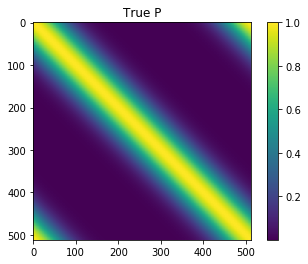

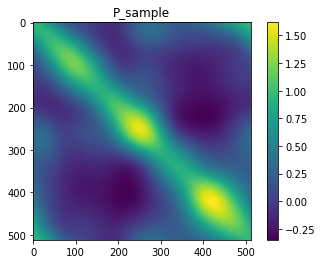

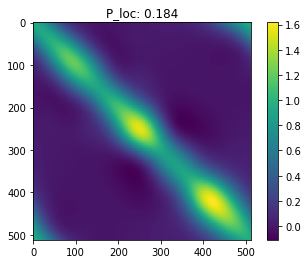

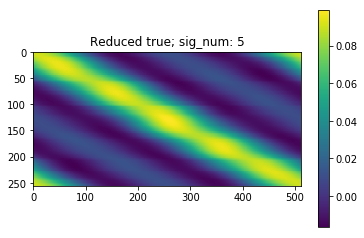

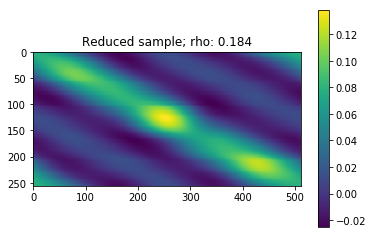

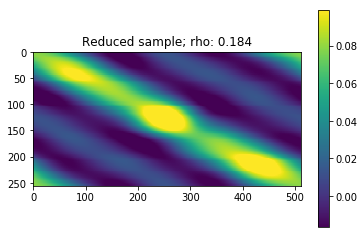

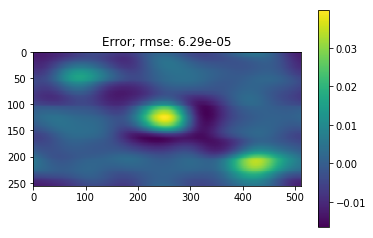

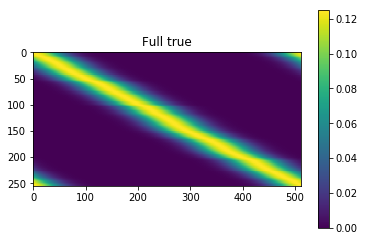

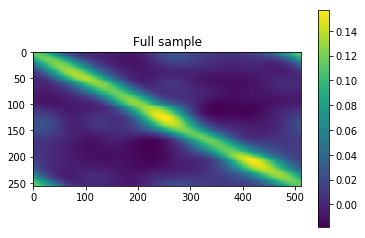

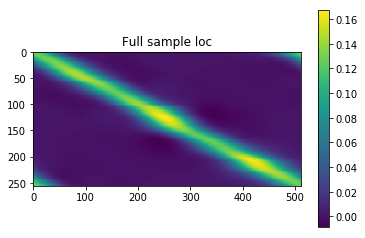

In [376]:
min_index = rmse.argmin()
rho_min = rho_array[min_index]

rho_loc = rho_min
[loc] = covariance.generate_circulant(
    dimension, dx, rho_loc, covariance.fft_sqd_exp_1d,
    return_Corr=True, return_eig=False)
loc /= loc.max() 
P_loc = P_sample * loc
imshow(P, f'True P')
imshow(P_sample, 'P_sample')
imshow(P_loc, f'P_loc: {rho_loc:0.3}')

this_trans_mats = assimilate.transformation_matrices(
    H, P=P_loc,
    R=R, return_Ts=True)
aU = this_trans_mats['U']
aS = this_trans_mats['S']
aVT = this_trans_mats['VT']
this_reduced = (aU[:, :sig_num]
                @ aS[:sig_num, :sig_num]
                @ aVT[:sig_num])
imshow(reduced_true, f'Reduced true; sig_num: {sig_num}')
imshow(this_reduced, f'Reduced sample; rho: {rho_loc:0.3}')
imshow(this_reduced, f'Reduced sample; rho: {rho_loc:0.3}',
       vmin=reduced_true.min(), vmax=reduced_true.max())
error = this_reduced - reduced_true
rmse[count] = (error ** 2).mean()
imshow(error, f'Error; rmse: {rmse[count]:0.4}')

full = (aU @ aS @ aVT)
full_sample = (U_sample @ S_sample @ VT_sample)
imshow(H @ P_sqrt, f'Full true')
imshow(full_sample, f'Full sample')
imshow(full, f'Full sample loc')